In [1]:
#import libraries
import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import sys

In [2]:
# directory & file hierarchy
proj_dir = os.path.abspath('../../..')
analysis_dir = os.getcwd()
exp_dir = os.path.abspath(os.path.join(os.getcwd(),'..','experiments'))
sketch_dir = os.path.abspath(os.path.join(os.getcwd(),'..','sketches'))

## add helpers to python path
if os.path.join(proj_dir,'analysis','python') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis','python'))
    
# Assign variables within imported analysis helpers
import analysis_helpers as h
if sys.version_info[0]>=3:
    from importlib import reload
reload(h)

<module 'analysis_helpers' from '/Users/megumisano/graphical_conventions/analysis/python/analysis_helpers.pyc'>

In [3]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['3dObjects']
coll = db['graphical_conventions']

# which iteration name should we use?
iterationName = 'run0_bonusmeter'

In [4]:
# count number of stroke and clickedobj records 
S = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'stroke'}]}).sort('time')
C = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'clickedObj'}]}).sort('time')
print str(S.count()) + ' stroke records in the database.'
print str(C.count()) + ' clickedObj records in the database.'

1180 stroke records in the database.
360 clickedObj records in the database.


In [5]:
# list of researcher mturk worker ID's to ignore
jefan = ['A1MMCS8S8CTWKU','A1MMCS8S8CTWKV','A1MMCS8S8CTWKS']
hawkrobe = ['A1BOIDKD33QSDK']
megsano = ['A1DVQQLVZR7W6I']
researchers = jefan + hawkrobe + megsano

In [6]:
# get list of all candidate games
games = coll.distinct('gameid')

# get list of complete and valid games, see analysis helpers for more details
complete_games = h.get_complete_and_valid_games(games,coll,researchers=researchers,tolerate_undefined_worker=False)

There was something wrong with this game 2306-68150396-3082-458b-bf35-5683428df704
There was something wrong with this game 2909-8200b9a1-435f-4c08-b71b-04bd71508910
There are 9 complete games in total.


In [8]:
# preprocessing 

TrialNum = []
GameID = []
Condition = []
Target = []
Distractor1 = []
Distractor2 = []
Distractor3 = []
Outcome = []
Response = []
Repetition = []
Phase = []
numStrokes = []
drawDuration = [] # in seconds
svgStringLength = [] # sum of svg string for whole sketch
svgStringLengthPerStroke = [] # svg string length per stroke
numCurvesPerSketch = [] # number of curve segments per sketch
numCurvesPerStroke = [] # mean number of curve segments per stroke
svgStringStd = [] # std of svg string length across strokes for this sketch
Outcome = []
png=[]

for g in complete_games:
        print 'Analyzing game: ', g

        # collection of all clickedObj events in a particular game 
        X = coll.find({ '$and': [{'gameid': g}, {'eventType': 'clickedObj'}]}).sort('time')
        # collection of all stroke events in a particular game 
        Y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}]}).sort('time')

        for t in X: # for each clickedObj event
            #print "new t"
            targetname = t['intendedName']
            Phase.append(t['phase'])
            Repetition.append(t['repetition'])
            distractors = [t['object2Name'],t['object3Name'],t['object4Name']]
            full_list = [t['intendedName'],t['object2Name'],t['object3Name'],t['object4Name']] 
            png.append(t['pngString'])

            #for each stroke event with same trial number as this particular clickedObj event 
            y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')
            lastStrokeNum = float(y[y.count() - 1]['currStrokeNum']) # get currStrokeNum at last stroke
            numStrokes.append(lastStrokeNum)
            startStrokeTime =  float(y[0]['startStrokeTime'])
            endStrokeTime = float(y[y.count() - 1]['endStrokeTime'])
            duration = (endStrokeTime - startStrokeTime) / 1000
            drawDuration.append(duration)
            ls = [len(_y['svgData']) for _y in y]
            svgStringLength.append(sum(ls))
            #svgStringLength.append(reduce(lambda x, y: x + y, ls))
            num_curves = [len([m.start() for m in re.finditer('c', _y['svgData'])]) for _y in y]
            #print num_curves # num_curves is empty... 
            numCurvesPerSketch.append(sum(num_curves))
            numCurvesPerStroke.append(sum(num_curves)/lastStrokeNum)
            svgStringLengthPerStroke.append(sum(ls)/lastStrokeNum)
            svgStringStd.append(np.std(ls))
#             numCurvesPerSketch.append(reduce(lambda x, y: x + y, num_curves))
#             numCurvesPerStroke.append(reduce(lambda x, y: x + y, num_curves)/lastStrokeNum)
#             svgStringLengthPerStroke.append(reduce(lambda x, y: x + y, ls)/lastStrokeNum)
    
            ### aggregate game metadata
            TrialNum.append(t['trialNum'])
            GameID.append(t['gameid'])        
            Target.append(targetname)
            Condition.append(t['condition'])
            Response.append(t['clickedName'])
            Outcome.append(t['correct'])
            Distractor1.append(distractors[0])
            Distractor2.append(distractors[1])
            Distractor3.append(distractors[2])  


Analyzing game:  2620-5551f382-59eb-4f99-9845-aa356379447c
Analyzing game:  1075-935838db-8153-428c-9f1a-2b7c68357508
Analyzing game:  6617-8b2133d7-7017-40e0-af39-08ca2b507db2
Analyzing game:  7373-d1cf7130-6d9e-4c17-9eaf-f128f3363a9d
Analyzing game:  0910-c7b8cea7-d989-4681-8e37-7553dd3bf37a
Analyzing game:  1180-2832f7d7-535a-4fb3-acf4-d40972f6d878
Analyzing game:  2207-2b879ad0-db06-4fa0-b705-a72bca57eac5
Analyzing game:  9920-64d6c563-fe36-41d2-a0ca-286261d1cebb
Analyzing game:  9114-90215f67-5c7f-467a-9664-cf43962b5daa


In [9]:
# debugging cell

In [10]:
# MAIN DATA
GameID,TrialNum,Condition, Target, Repetition, Phase, drawDuration, Outcome, Response, numStrokes, svgStringLength, svgStringLengthPerStroke, svgStringStd, png = map(np.array, \
[GameID,TrialNum,Condition, Target, Repetition, Phase, drawDuration,Outcome, Response, numStrokes, svgStringLength, svgStringLengthPerStroke, svgStringStd, png])    

Repetition = map(int,Repetition)

D = pd.DataFrame([GameID,TrialNum,Condition, Target, Repetition, Phase, drawDuration,Outcome, Response, numStrokes, svgStringLength, svgStringLengthPerStroke, svgStringStd, png], index = ['gameID','trialNum','condition', 'target', 'repetition', 'phase', 'drawDuration','outcome', 'response', 'numStrokes', 'svgStringLength', 'svgStringLengthPerStroke', 'svgStringStd', 'png'])
D = D.transpose()
D

,gameID,trialNum,condition,target,repetition,phase,drawDuration,outcome,response,numStrokes,svgStringLength,svgStringLengthPerStroke,svgStringStd,png
0,2620-5551f382-59eb-4f99-9845-aa356379447c,1,control,inlay,0,pre,15.572,True,inlay,11,1635,148.636,148.545,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
1,2620-5551f382-59eb-4f99-9845-aa356379447c,2,repeated,squat,0,pre,3.239,False,knob,2,259,129.5,45.5,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
2,2620-5551f382-59eb-4f99-9845-aa356379447c,3,control,leather,0,pre,18.983,True,leather,9,1726,191.778,193.583,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
3,2620-5551f382-59eb-4f99-9845-aa356379447c,4,control,waiting,0,pre,14.05,True,waiting,5,833,166.6,107.677,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
4,2620-5551f382-59eb-4f99-9845-aa356379447c,5,repeated,straight,0,pre,5.051,True,straight,5,299,59.8,24.49,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
5,2620-5551f382-59eb-4f99-9845-aa356379447c,6,control,sling,0,pre,4.298,True,sling,4,342,85.5,55.0205,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
6,2620-5551f382-59eb-4f99-9845-aa356379447c,7,repeated,knob,0,pre,3.12,True,knob,1,220,220,0,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
7,2620-5551f382-59eb-4f99-9845-aa356379447c,8,repeated,woven,0,pre,14.161,True,woven,5,862,172.4,159.963,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
8,2620-5551f382-59eb-4f99-9845-aa356379447c,9,repeated,squat,1,repeated,7.732,True,squat,4,523,130.75,58.4482,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
9,2620-5551f382-59eb-4f99-9845-aa356379447c,10,repeated,knob,1,repeated,3.127,True,knob,1,322,322,0,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...


In [40]:
## sanity checks on data 

## does each objects show up in the data frame the expected number of times
D.groupby('target')['target'].count()



target
basset              4
beetle             14
bloodhound         16
bluejay            10
bluesedan          21
bluesport          21
brown              28
bullmastiff        10
chihuahua          16
crow               17
cuckoo              4
doberman           10
goldenretriever    10
hatchback          14
inlay               2
knob                8
leather             2
nightingale        10
pigeon             10
pug                10
redantique         13
redsport           26
robin               4
sling               2
sparrow            16
squat               8
straight            8
tomtit              9
waiting             2
weimaraner          4
white              23
woven               8
Name: target, dtype: int64

In [ ]:
# TODO
#0 numCurves empty 
#1 look at individual targets -actual sketches 
#2 accuracy 
#3 repeated vs control

# summary statistics

In [106]:
# get summary statistics - change
#all_games = np.unique(D['gameID'])
repeated_strokes = []
control_strokes = []
repeated_svgLength = []
control_svgLength = []
repeated_svgStd = []
control_svgStd = []
repeated_svgLengthPS = []
control_svgLengthPS = []
repeated_drawDuration = []
control_drawDuration = []
repeated_accuracy = []
control_accuracy = []
for game in complete_games:    
    criteria_repeated = (D['gameID'] == game) & (D['condition']=='repeated')
    criteria_control = (D['gameID'] == game) & (D['condition']=='control')
    repeated_strokes.append((D[criteria_repeated])['numStrokes'].mean()) 
    control_strokes.append((D[criteria_control])['numStrokes'].mean()) 
    repeated_svgLength.append((D[criteria_repeated])['svgStringLength'].mean())
    control_svgLength.append((D[criteria_control])['svgStringLength'].mean())
    repeated_svgStd.append((D[criteria_repeated])['svgStringStd'].mean())
    control_svgStd.append((D[criteria_control])['svgStringStd'].mean())
    repeated_svgLengthPS.append((D[criteria_repeated])['svgStringLengthPerStroke'].mean())
    control_svgLengthPS.append((D[criteria_control])['svgStringLengthPerStroke'].mean())
    repeated_drawDuration.append((D[criteria_repeated])['drawDuration'].mean())
    control_drawDuration.append((D[criteria_control])['drawDuration'].mean())
    repeated_accuracy.append((D[criteria_repeated])['outcome'].mean())
    control_accuracy.append((D[criteria_control])['outcome'].mean())
    
repeated_strokes, control_strokes, repeated_svgLength, control_svgLength, \
repeated_svgStd, control_svgStd, repeated_svgLengthPS, control_svgLengthPS, \
repeated_drawDuration, control_drawDuration, repeated_accuracy, control_accuracy = map(np.array, \
[repeated_strokes, control_strokes, repeated_svgLength, control_svgLength,\
 repeated_svgStd, control_svgStd, repeated_svgLengthPS, control_svgLengthPS, \
repeated_drawDuration, control_drawDuration, repeated_accuracy, control_accuracy])

 # analysis across repetitions

In [26]:
# Plotting a variable against numReps (averaged across objects)

def plotAcrossRepeats(variable, # the variable you want to see plotted against numRepts 
                                        numReps, # number of repetitions across which you want to see the change 
                                        D,
                                        limit): #dataframe
    
    # repeated conditions 
    criteria_repeated = (D['condition']=='repeated')
    repeated = D[criteria_repeated] # get all repeated condition trials 
    repeats = list(range(0, numReps)) # number of repeats
    repeated_means = []
    for rep in repeats:
        mean = ((repeated[(repeated['repetition'] == rep)])[variable]).mean()  # get mean across trials with same repetition number
        repeated_means.append(mean)

    # control conditions 
    criteria_control = (D['condition']=='control')
    control = D[criteria_control] # get all control condition trials 
    controls = [0, numReps - 1] # number of controls scaled up to total number of repeats 
    control_means= []
    for i in [0, 1]: # only 2 controls, but should scale up to numReps 
        mean = ((control[(control['repetition'] == i)])[variable]).mean() # get mean across trials with same repetition number
        control_means.append(mean)

    plt.scatter(x = repeats, y = repeated_means, label='repeated')
    plt.scatter(x = controls, y = control_means, label = 'control')
    plt.xlabel('numRep')
    plt.ylabel(variable)
    axes = plt.gca()
    axes.set_ylim([0,limit])
    fig = plt.gcf()

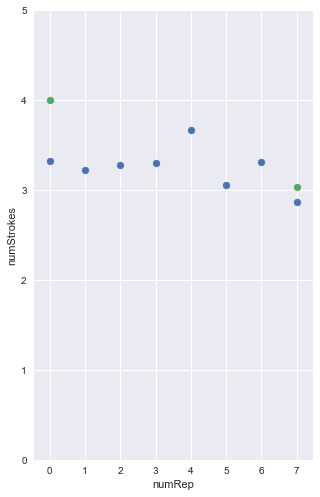

In [32]:
plotAcrossRepeats('numStrokes', 8, D, 5)

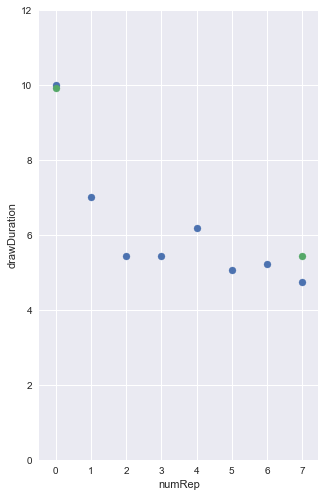

In [36]:
plotAcrossRepeats('drawDuration', 8, D, 12)

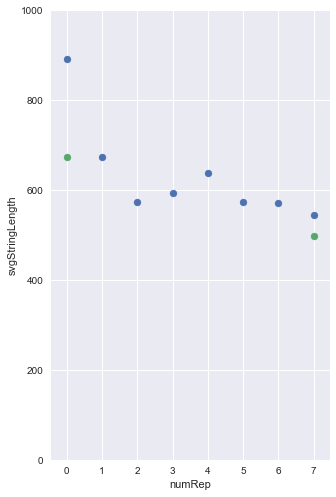

In [37]:
plotAcrossRepeats('svgStringLength', 8, D ,1000)

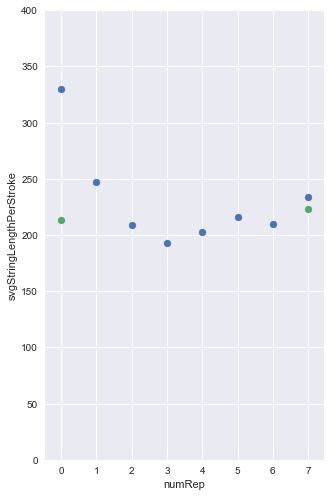

In [38]:
plotAcrossRepeats('svgStringLengthPerStroke', 8, D, 400)

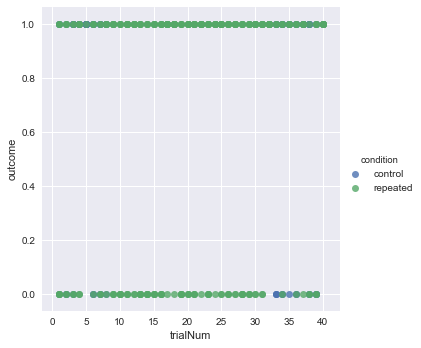

In [39]:
# debug cell
sns.set(rc={'figure.figsize':(5,8.27)})
d = pd.DataFrame()
d['trialNum'] =D['trialNum']
d['numStrokes'] = D['numStrokes']
d['condition'] = D['condition']
d['outcome'] = D['outcome']
#d['control'] = control_means
facet = sns.lmplot(data=d, x='trialNum', y='numStrokes', fit_reg=False, hue = 'condition', markers=['o', 'x'])

# Miscellaneous

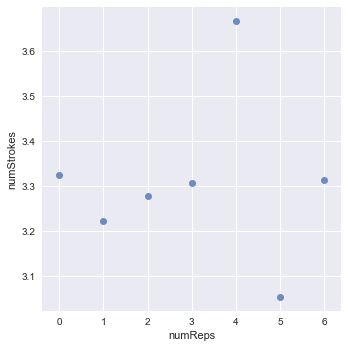

In [31]:
#seaborn plotting

d = pd.DataFrame()
numReps = 7
variable = 'numStrokes'
# repeated conditions 
criteria_repeated = (D['condition']=='repeated')
repeated = D[criteria_repeated] # get all repeated condition trials 
repeats = list(range(0, numReps)) # number of repeats
repeated_means = []
for rep in repeats:
    mean = ((repeated[(repeated['repetition'] == rep)])[variable]).mean()  # get mean across trials with same repetition number
    repeated_means.append(mean)

# control conditions 
criteria_control = (D['condition']=='control')
control = D[criteria_control] # get all control condition trials 
controls = [0, numReps - 1] # number of controls scaled up to total number of repeats 
control_means= []
for i in [0, 1]: # only 2 controls, but should scale up to numReps 
    mean = ((control[(control['repetition'] == i)])[variable]).mean() # get mean across trials with same repetition number
    control_means.append(mean)

d['numReps'] = repeats
d[variable] = repeated_means
#d['control'] = control_means
facet = sns.lmplot(data=d, x='numReps', y=variable, fit_reg=False)
# add error bars 

In [107]:
print repeated_strokes.mean(), control_strokes.mean()
print repeated_svgLength.mean(), control_svgLength.mean()
print repeated_svgStd.mean(), control_svgStd.mean()
print repeated_svgLengthPS.mean(), control_svgLengthPS.mean()
print repeated_drawDuration.mean(), control_drawDuration.mean()
print repeated_accuracy.mean(), control_accuracy.mean()

3.25220959596 3.51587301587
632.763468013 587.255952381
98.1924092084 85.2462202873
230.442191007 217.817577991
6.1431875 7.73814484127
0.0310395622896 0.128968253968


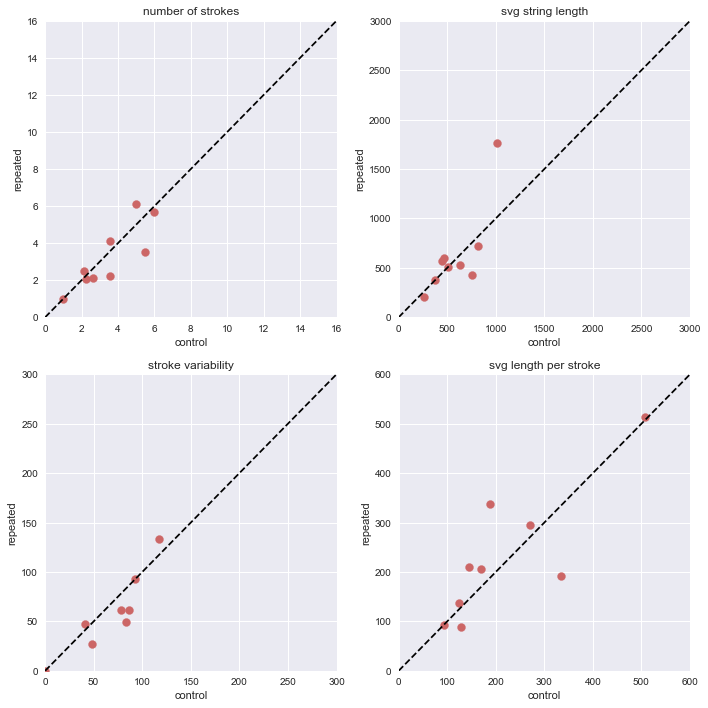

In [108]:
fig = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
lb = 0
ub = 16
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_strokes,repeated_strokes,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('number of strokes')
plt.xlabel('control')
plt.ylabel('repeated')
plt.subplot(2,2,2)
lb = 0
ub = 3000
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_svgLength,repeated_svgLength,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.tight_layout()
plt.title('svg string length')
plt.xlabel('control')
plt.ylabel('repeated')
plt.subplot(2,2,3)
lb = 0
ub = 300
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_svgStd,repeated_svgStd,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('stroke variability')
plt.xlabel('control')
plt.ylabel('repeated')
plt.subplot(2,2,4)
lb = 0
ub = 600
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_svgLengthPS,repeated_svgLengthPS,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.tight_layout()
plt.title('svg length per stroke')
plt.xlabel('control')
plt.ylabel('repeated')

In [21]:
a = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'clickedObj'}, {'time':{'$gt':1531160581750, '$lt': 1531161932801}}]}).sort('time')
for rec in a:
    print rec['phase'], rec['condition'],rec['repetition']

pre repeated 0
pre repeated 0
pre control 0
pre repeated 0
pre repeated 0
pre control 0
pre control 0
pre control 0
repeated repeated 1
repeated repeated 1
repeated repeated 1
repeated repeated 1
repeated repeated 2
repeated repeated 2
repeated repeated 2
repeated repeated 2
repeated repeated 3
repeated repeated 3
repeated repeated 3
repeated repeated 3
repeated repeated 4
repeated repeated 4
repeated repeated 4
repeated repeated 4
repeated repeated 5
repeated repeated 5
repeated repeated 5
repeated repeated 5
repeated repeated 6
repeated repeated 6
repeated repeated 6
repeated repeated 6
post repeated 7
post control 1
post repeated 7
post control 1
post repeated 7
post control 1
post repeated 7
post control 1
